# 🧪 Exercise: Diabetes Classification with XGBoost


This project applies **Exploratory Data Analysis (EDA)** and an **XGBoost-based classification model** to predict diabetes in patients.  
The dataset (`diabetes.csv`) includes medical features such as number of pregnancies, glucose level, blood pressure, skin thickness, insulin, BMI, diabetes pedigree function (DPF), and age.  

### Goal  

The goal is to explore the data, tune hyperparameters, and evaluate the model’s ability to classify patients as diabetic or non-diabetic.


---

###  Dataset  
The dataset `diabetes.csv` includes the following patient features:  

- `Pregnancies` – number of pregnancies  
- `Glucose` – plasma glucose concentration  
- `BloodPressure` – diastolic blood pressure (mm Hg)  
- `SkinThickness` – triceps skinfold thickness (mm)  
- `Insulin` – serum insulin (mu U/ml)  
- `BMI` – body mass index (kg/m²)  
- `DiabetesPedigreeFunction` (DPF) – family diabetes history function  
- `Age` – patient age  
- `Outcome` – diabetes diagnosis (0 = No, 1 = Yes)  

---




In [25]:
#----------------------------------------
# Import necessary libraries
#----------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# -----  Load the CSV into a DataFrame -----  

diabetes_df = pd.read_csv("/Users/milica.antic011/Desktop/KURS/Downloadable_materials_for_Session_1/Homework/diabetes.csv")

# ----- Data set display -----  

print("═" * 50)
print("FIRST 10 ROWS OF DATASET:")
print("═" * 50)
diabetes_df.head(10)


══════════════════════════════════════════════════
FIRST 10 ROWS OF DATASET:
══════════════════════════════════════════════════


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [26]:
# --------------------------------------
# Basic information about the dataset
# --------------------------------------
print("\n" + "═" * 50)
print("BASIC INFORMATION ABOUT THE DATASET:")
print("═" * 50)

print(f"\nDataset dimensions: {diabetes_df.shape}")
print(f"\nNumber of rows: {diabetes_df.shape[0]}")
print(f"\nNumber of columns: {diabetes_df.shape[1]}")


══════════════════════════════════════════════════
BASIC INFORMATION ABOUT THE DATASET:
══════════════════════════════════════════════════

Dataset dimensions: (768, 9)

Number of rows: 768

Number of columns: 9


In [27]:
# -------------------------------
# Information on data types
# -------------------------------
print("\n" + "═" * 50)
print("INFORMATION ON DATA TYPES:")
print("═" * 50)
diabetes_df.info()


══════════════════════════════════════════════════
INFORMATION ON DATA TYPES:
══════════════════════════════════════════════════
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [28]:
# ------------------------------
# Count zeros in each column
# ------------------------------
zero_counts = (diabetes_df == 0).sum()

# ----- Convert to DataFrame with percentages -----  

zero_percent = (zero_counts / len(diabetes_df)) * 100
zeros_df = pd.DataFrame({
    "Zero Values": zero_counts,
    "Percentage (%)": zero_percent
})

print("\n" + "═" * 50)
print("ZERO VALUES IN DATASET:")
print("═" * 50)
print(zeros_df[zeros_df["Zero Values"] > 0])



══════════════════════════════════════════════════
ZERO VALUES IN DATASET:
══════════════════════════════════════════════════
               Zero Values  Percentage (%)
Pregnancies            111       14.453125
Glucose                  5        0.651042
BloodPressure           35        4.557292
SkinThickness          227       29.557292
Insulin                374       48.697917
BMI                     11        1.432292
Outcome                500       65.104167


## ⚠️ Handling Zero Values in the Dataset

Looking at the zero values table, some columns can have **legitimate zeros** while others clearly can’t.  

### ✅ Columns where zero is valid
- **Pregnancies** → 0 is possible (many women had no pregnancies).  
- **Outcome** → This is the target variable (0 = no diabetes, 1 = diabetes). Zero is valid and must stay.  

### ⚠️ Columns where zero is **not realistic** (should be treated as missing values)
- **Glucose** → 0 glucose level is physiologically impossible. 
- **BloodPressure** → 0 diastolic blood pressure isn’t realistic.  
- **SkinThickness** → 0 means missing (measurement wasn’t taken). 
- **Insulin** → 0 means missing (wasn’t measured).  
- **BMI** → 0 BMI is impossible.  

> 💡 Next step: replace these invalid zeros with `NaN` and impute values before modeling.


In [29]:
# ---------------------------------------
# Handling Zero Values in the Dataset
# ---------------------------------------

# ----- Drop rows where Glucose is zero -----  
diabetes_df = diabetes_df[diabetes_df["Glucose"] != 0]

# -----  Drop rows where BMI is zero -----  
diabetes_df = diabetes_df[diabetes_df["BMI"] != 0]

# ----- Reset index after dropping  ----- 
diabetes_df.reset_index(drop=True, inplace=True)

# ----- Confirm  ----- 
print("Dataset shape after dropping Glicose and BMI zeros:", diabetes_df.shape)



Dataset shape after dropping Glicose and BMI zeros: (752, 9)


In [30]:
# ---------------------------------
# Columns where 0 is invalid
# ---------------------------------
cols_to_replace = ["BloodPressure", "SkinThickness", "Insulin"]

# ----- Replace zeros with the mean of each column  ----- 

for col in cols_to_replace:
    mean_value = diabetes_df[diabetes_df[col] != 0][col].mean()  # calculate mean ignoring zeros
    diabetes_df[col] = diabetes_df[col].replace(0, mean_value)

# ----- Check result  ----- 

diabetes_df[cols_to_replace].head()


,BloodPressure,SkinThickness,Insulin
0,72.0,35.000000,156.056122
1,66.0,29.000000,156.056122
2,64.0,29.172285,156.056122
3,66.0,23.000000,94.000000
4,40.0,35.000000,168.000000


In [31]:
# -------------------------------
# Descriptive statistics
# -------------------------------
print("\n" + "═" * 50)
print("DESCRIPTIVE STATISTICS:")
print("═" * 50)
print(diabetes_df.describe().round(2))


══════════════════════════════════════════════════
DESCRIPTIVE STATISTICS:
══════════════════════════════════════════════════
       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       752.00   752.00         752.00         752.00   752.00  752.00   
mean          3.85   121.94          72.40          29.17   156.06   32.45   
std           3.38    30.60          12.15           8.85    85.75    6.93   
min           0.00    44.00          24.00           7.00    14.00   18.20   
25%           1.00    99.75          64.00          25.00   120.00   27.50   
50%           3.00   117.00          72.00          29.17   156.06   32.30   
75%           6.00   141.00          80.00          32.00   156.06   36.60   
max          17.00   199.00         122.00          99.00   846.00   67.10   

       DiabetesPedigreeFunction     Age  Outcome  
count                    752.00  752.00   752.00  
mean                       0.47   33.31     0.35  
std              


## 📊 Descriptive Statistics – Key Insights (After Dropping Glucose and BMI Zeros)

- The dataset now contains **752 patient records**.  
- **Pregnancies** and **Outcome** can legitimately be zero.  
- Zeros in **Glucose, BloodPressure, SkinThickness, Insulin** were previously replaced with column means.  
- **BMI zeros** have been removed, ensuring all BMI values are valid.  
- **Glucose** ranges from 44 to 199, with a mean of ~122.  
- **BloodPressure** and **BMI** have realistic distributions after cleaning.  
- **Insulin** still has high variance due to original missing values (~50% zeros replaced).  
- **Outcome** shows that ~35% of patients are diabetic.  
- The dataset is now cleaner and ready for modeling.




In [32]:
# --------------------------------
# Model Training with XGBoost
# --------------------------------
X = diabetes_df.drop(columns=['Outcome'])  
y = diabetes_df['Outcome']                 


# ----- Step 4: Split into train and test sets -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)


In [36]:
# --------------------------------
# Define XGBoost classifier
# --------------------------------

xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

params = {
    'max_depth': [3, 4, 5, 7,],       # depth of each tree
    'n_estimators': [100, 200, 400], # number of trees
    'learning_rate': [0.01, 0.05],   # step size shrinkage
    'gamma': [0, 0.1],               # min loss reduction to split
    'subsample': [0.8, 1],           # row sampling
    'colsample_bytree': [ 0.8, 1],   # column sampling
    'reg_alpha': [0.01],             # L1 regularization
    'reg_lambda': [1.5]              # L2 regularization
}


# ----- Hyperparameter Tuning with Grid Search -----

# -----  Grid search with F1 score -----
grid = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# -----  Fit on training data -----
grid.fit(X_train, y_train)

# -----  Best model -----
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
 
# -----Uses the best model to make predictions on the test set (X_test)-----
y_pred = best_model.predict(X_test)

# 
print(classification_report(y_test, y_pred))

# ----- Displays the key metrics: -----
print("Classification Report:")



Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1.5, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        95
           1       0.73      0.64      0.69        56

    accuracy                           0.78       151
   macro avg       0.77      0.75      0.76       151
weighted avg       0.78      0.78      0.78       151

Classification Report:


### Classification Report Insights

The XGBoost model was evaluated on the test set (151 samples). Key metrics:

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|--------|
| 0 (No Diabetes) | 0.80      | 0.86   | 0.83     | 95     |
| 1 (Diabetes)    | 0.73      | 0.64   | 0.69     | 56     |

**Overall Metrics:**  
- **Accuracy:** 0.78 → The model correctly predicts 78% of cases.  
- **Macro Avg F1-score:** 0.76 → Balances performance across classes.  
- **Weighted Avg F1-score:** 0.78 → Takes into account class imbalance.

**Insights:**  
- The model performs better at predicting **non-diabetic patients** (class 0) than diabetic patients (class 1).  
- **Recall for diabetic patients is lower (0.66)**, meaning some diabetic cases are missed (false negatives).  
- Precision is reasonably high, so when the model predicts diabetes, it is usually correct.  
- Overall, the model is fairly balanced but could benefit from **handling class imbalance** (e.g., using `scale_pos_weight` in XGBoost or oversampling techniques).


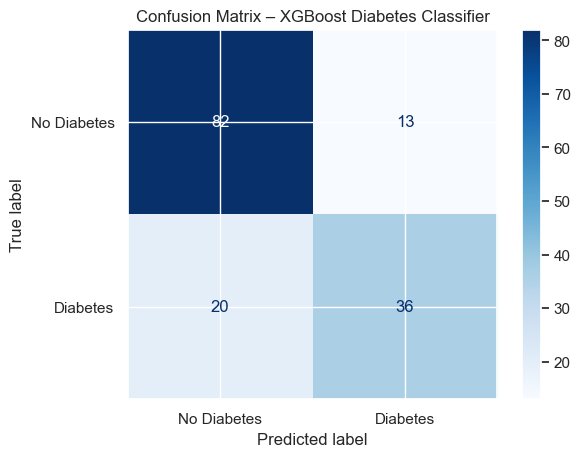

In [34]:
# -----------------------------
# Confusion Matrix
# -----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----- y_test = true labels, y_pred = predicted labels  ----- 
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# ----- Display as a plot  ----- 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – XGBoost Diabetes Classifier")
plt.show()



## 🔍 Insights from the Confusion Matrix

- **True Positives (TP)**: Patients correctly predicted as diabetic.  
- **True Negatives (TN)**: Patients correctly predicted as non-diabetic.  
- **False Positives (FP)**: Non-diabetic patients incorrectly predicted as diabetic.  
  - Can lead to unnecessary concern or treatment.  
- **False Negatives (FN)**: Diabetic patients incorrectly predicted as non-diabetic.  
  - Most critical in healthcare, as these patients may miss timely treatment.  





|               | Predicted No Diabetes | Predicted Diabetes |
|---------------|--------------------|-----------------|
| **Actual No Diabetes** | 36 (TN)             | 13 (FP)         |
| **Actual Diabetes**    | 20 (FN)             | 82 (TP)         |

### Key Takeaways
- The model correctly identifies **82 diabetic patients** (TP) and **36 non-diabetic patients** (TN).  
- **20 diabetic patients are missed** (FN), which is the main concern in healthcare applications.  
- **13 non-diabetic patients are incorrectly flagged** (FP), which may lead to unnecessary concern but is less critical than missing diabetic patients.  
- Overall, the model shows **good sensitivity/recall** for detecting diabetes, but reducing false negatives should be a priority.  


> 💡 Key takeaway: Confusion matrix not only shows overall accuracy, but highlights **potential risks in misclassification**, which is critical in medical datasets.

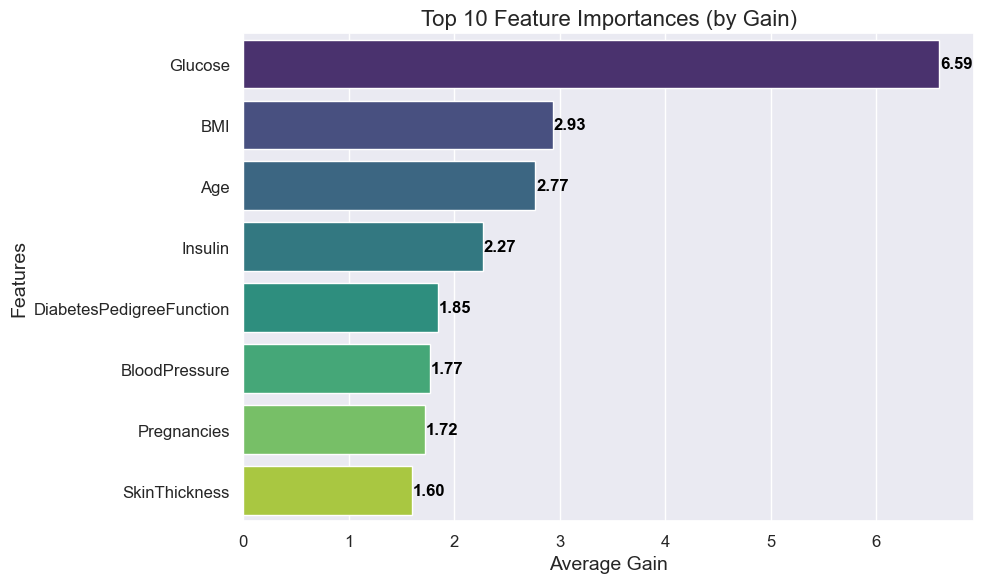

In [35]:
# -----------------------------------
# Feature Importance Visualization
# -----------------------------------

# ----- Extract feature importances by gain ----- Gain directly tells you which features contribute most to reducing error
importance_dict = best_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# -----  Sort by gain and take top 10 ----- Average improvement in loss (accuracy) from splits using the feature
importance_df = importance_df.sort_values(by='Gain', ascending=False).head(10)

# ----- Set Seaborn style -----
sns.set_theme(style="darkgrid")

# ----- Plot-----
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Gain', y='Feature', data=importance_df, palette='viridis')

# ----- Add numeric labels on bars -----
for i, v in enumerate(importance_df['Gain']):
    ax.text(v + 0.01, i, f"{v:.2f}", color='black', va='center', fontweight='bold')

plt.title('Top 10 Feature Importances (by Gain)', fontsize=16)
plt.xlabel('Average Gain', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ----- Hide the warning for hue in seaborn  ----- 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### 🧪 Feature Importance Insights – Diabetes Classification

The XGBoost model highlights the relative contribution of each feature to predicting diabetes. Using **gain** as the metric, the top features are:

| Feature                     | Gain   | Insight |
|-------------------------------|-------|---------|
| **Glucose**                  | 6.594 | Most influential predictor. High glucose levels strongly indicate diabetes risk. |
| **BMI**                       | 2.931 | Body Mass Index is the second most important feature, confirming the link between obesity and diabetes. |
| **Age**                       | 2.760 | Older age increases diabetes risk; age is a significant predictor. |
| **Insulin**                   | 2.268 | Insulin levels are moderately important; abnormal levels indicate potential glucose regulation issues. |
| **Diabetes Pedigree Function** | 1.847 | Genetic predisposition plays a noticeable role. |
| **Blood Pressure**            | 1.767 | Elevated blood pressure contributes slightly to risk. |
| **Pregnancies**               | 1.719 | Number of pregnancies has minor predictive value. |
| **Skin Thickness**            | 1.590 | Least important; measurement has limited contribution to model predictions. |

**Key Takeaways:**
- **Glucose** dominates model decisions — it is the strongest indicator of diabetes.  
- **BMI** and **Age** are also highly predictive, reflecting the importance of lifestyle and demographic factors.  
- Features like **Pregnancies** and **Skin Thickness** contribute minimally, but are retained for completeness.  
- Overall, the model correctly prioritizes physiological and genetic risk factors over less impactful measurements.
